In [1]:
#The following code simulates a one-factor model CIR process described by the following SDE: drt=a(b−rt)dt+σrt−−√dWt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# Plot settings
plt.rcParams['figure.figsize'] = (9,6)
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False
pal = ["#FBB4AE","#B3CDE3", "#CCEBC5","#CFCCC4"]

def simulate_cir_small(mu, theta, sigma, X0, T, N):
    dt = T / N
    t = np.arange(dt, T + dt, dt)
    dB = np.sqrt(dt) * np.random.randn(N)
    X = np.empty(N)
    X[0] = X0

    X_em_small, X = [], X0
    for j in range(N):  
        X += theta*(mu-X)*dt + sigma*np.sqrt(X)*dB[j]
        X_em_small.append(X)
    
    # Plot the simulated data
    plt.figure(figsize=(12,8)) 
    plt.plot(t, X_em_small, label="EM ($X_t$): Fine Grid", color=pal[0], ls='--')
    plt.title('E-M Approximation'); plt.xlabel('t'); plt.legend(loc = 2);

    return  X_em_small


def simulate_cir_big(mu, theta, sigma, X0, T, N):
    dt = T / N
    t = np.arange(dt, T + dt, dt)
    dB = np.sqrt(dt) * np.random.randn(N)
    X = np.empty(N)
    X[0] = X0

    X_em_big, X, R = [], X0, 2
    coarse_grid = np.arange(dt,1+dt,R*dt)
    for j in range(int(N/R)):
        X += theta*(mu-X) * (R*dt) + sigma*np.sqrt(X)*sum(dB[R*(j-1):R*j])
        X_em_big.append(X)    
    
    # Plot
    # plt.plot(t, Y, label="Exact ($Y_t$)", color=pal[0])
    plt.figure(figsize=(12,8)) 
    plt.plot(coarse_grid, X_em_big, label="EM ($X_t$): Coarse Grid", color=pal[1], ls='--')
    plt.title('E-M Approximation'); plt.xlabel('t'); plt.legend(loc = 2);
    return t, X_em_big





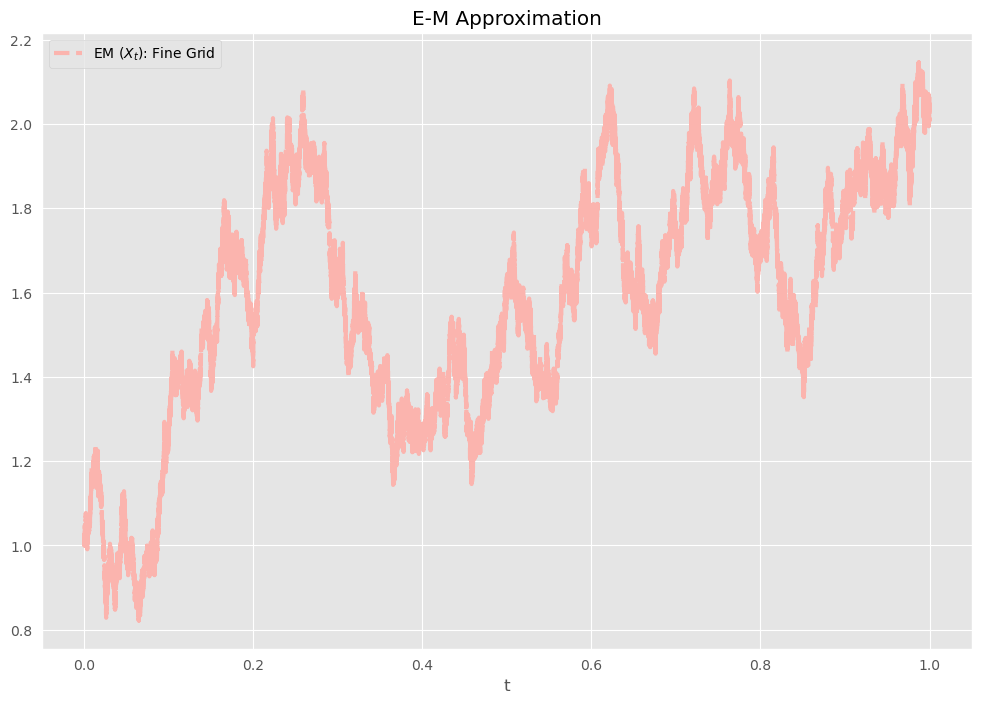

In [2]:
# Simulate CIR process
simulated_data = simulate_cir_small(2, 1, 1, 1, 1, 2**20)



In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Load historical data from CSV file
path = r'Y:\Risk\000 - Market Risk\00 - Python\Data\PFE\\'
historical_data = pd.read_csv(path + 'US_IR.csv')['IR'].values

####### Function for CIR Simulation using EM ############

def simulate_cir_small_1(mu, theta, sigma, X0, T, N):
    X_store = []
    dt = T / N
    t = np.arange(dt, T + dt, dt)
    dB = np.sqrt(dt) * np.random.randn(N)
    X = np.empty(N, dtype=float)  # Ensure X is of the desired data type
    X[0] = X0

    for j in range(1, N):
        X[j] = X[j - 1] + theta * (mu - X[j - 1]) * dt + sigma * np.sqrt(X[j - 1]) * dB[j]
        X_store.append(X[j].copy())  # Append a copy of X[j] to X_store
    
    return X_store



# Define the corrected objective function
def objective_function(params):
    difference_sum = 0  # Initialize the difference sum
    mu, theta, sigma, X0, T, N = params
    simulated_data = simulate_cir_small_1(theta, mu, sigma, X0, T, N)
    difference_sum += historical_data[:N-1] - simulated_data[:N]
    return np.sum(difference_sum)**2

#Minimize to get parameters for EM to be as close as possible to historical data.
# Initial parameter values for optimization

# Initial values for mu, theta, sigma, X0, T, N
initial_params = [1, 1, 1, 1, 1, 60]  


In [41]:
objective_function(initial_params)


18715.834691000375

In [42]:
# Perform optimization
result = minimize(objective_function, initial_params, method='BFGS')



# Get the optimized parameter values
optimized_params = result.x
mu_opt, theta_opt, sigma_opt, X0_opt, T_opt, N_opt_float = optimized_params

# Convert N_opt to an integer
N_opt = int(N_opt_float)

# Simulate the CIR process using the optimized parameters
t_opt, simulated_data_opt = simulate_cir_small_1(mu_opt, theta_opt, sigma_opt, X0_opt, T_opt, N_opt)

# Plot the results for comparison
plt.plot(t_opt, simulated_data_opt, label="Simulated (Optimized)", color='blue', ls='-')
plt.plot(t_opt, historical_data, label="Historical Data", color='orange', ls='-')
plt.legend(loc='best')
plt.title('CIR Model Calibration and Comparison')
plt.xlabel('t')
plt.ylabel('IR')
plt.show()



TypeError: 'numpy.float64' object cannot be interpreted as an integer